# 过去三个月 预测一个月

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense,Activation,Embedding,LSTM
import matplotlib.pyplot as plt
from tensorflow import keras
import  numpy as np  
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas.core.algorithms import mode
# make a prediction
from tensorflow.python.keras.backend import concatenate
from sklearn.metrics import mean_squared_error

#设置gpu
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print('exist!')
    gpu0 = gpus[0]
    tf.config.experimental.set_memory_growth(gpu0,True)
    tf.config.set_visible_devices([gpu0],'GPU')


# convert series to supervised learning 得到训练的数据格式
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    raw_columns = data.columns.values
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (raw_columns[j%n_vars], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (raw_columns[j%n_vars])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (raw_columns[j%n_vars], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [2]:
#导入数据
cpi =pd.read_csv('D:/B/T0002/export/02_38#CPI.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()
usdcny = pd.read_csv('D:/B/T0002/export/02_10#USDCNY.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()
rpi =pd.read_csv('D:/B/T0002/export/02_38#RPI.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()
M1 =pd.read_csv('D:/B/T0002/export/02_38#M1.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()
M2 =pd.read_csv('D:/B/T0002/export/02_38#M2.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()
ppi =pd.read_csv('D:/B/T0002/export/02_38#PPI.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()
cci =pd.read_csv('D:/B/T0002/export/02_38#CCI.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()
aue =pd.read_csv('D:/B/T0002/export/02_38#AUE.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()
trd =pd.read_csv('D:/B/T0002/export/02_38#TRD.csv',skiprows=[0,1],encoding='gbk',names = ['date','open','high','low','close','volum','account']).dropna()


In [3]:
cpi

,date,open,high,low,close,volum,account
0,2000-01-31,99.8,99.8,99.8,99.8,0.0,0.0
1,2000-02-29,100.7,100.7,100.7,100.7,0.0,0.0
2,2000-03-31,99.8,99.8,99.8,99.8,0.0,0.0
3,2000-04-30,99.7,99.7,99.7,99.7,0.0,0.0
4,2000-05-31,100.1,100.1,100.1,100.1,0.0,0.0
...,...,...,...,...,...,...,...
266,2022-03-31,101.5,101.5,101.5,101.5,0.0,0.0
267,2022-04-30,102.1,102.1,102.1,102.1,0.0,0.0
268,2022-05-31,102.1,102.1,102.1,102.1,0.0,0.0
269,2022-06-30,102.5,102.5,102.5,102.5,0.0,0.0


In [4]:
def preprocess(x):
    x.date = pd.to_datetime(x.date)
    x.set_index('date',inplace=True)
    return x[['close']]
cpi = preprocess(cpi)
ppi = preprocess(ppi)
M1 = preprocess(M1)
M2 = preprocess(M2)
cci = preprocess(cci)

rpi = preprocess(rpi)
aue = preprocess(aue)
trd = preprocess(trd)

In [5]:
usdcny.date = pd.to_datetime(usdcny.date)
usdcny['date'] = usdcny['date'].dt.strftime('%Y-%m')

usdcny = usdcny.groupby('date').mean()[['close']]
usdcny.columns = ['usdcny']
usdcny




,usdcny
date,
2005-11,8.082062
2005-12,8.074619
2006-01,8.064214
2006-02,8.049647
2006-03,8.032913
...,...
2022-04,6.432067
2022-05,6.698318
2022-06,6.696245


In [6]:
usdcny.values

array([[8.0820625 ],
       [8.07461905],
       [8.06421429],
       [8.04964706],
       [8.03291304],
       [8.01295   ],
       [8.01288889],
       [8.00540909],
       [7.98866667],
       [7.9726087 ],
       [7.93404762],
       [7.9025    ],
       [7.86313636],
       [7.82209524],
       [7.78804762],
       [7.75175   ],
       [7.73840909],
       [7.72514286],
       [7.66942105],
       [7.63190476],
       [7.57618182],
       [7.57317391],
       [7.52245   ],
       [7.50166667],
       [7.42013636],
       [7.36809524],
       [7.24445455],
       [7.16373684],
       [7.07319048],
       [6.99822727],
       [6.97209524],
       [6.8982381 ],
       [6.83756522],
       [6.8522381 ],
       [6.83709091],
       [6.83578261],
       [6.82815   ],
       [6.85365217],
       [6.83666667],
       [6.837     ],
       [6.83677273],
       [6.83145455],
       [6.82345   ],
       [6.83440909],
       [6.83256522],
       [6.83304762],
       [6.82859091],
       [6.827

In [ ]:
len(info)

8242408

In [7]:
t = pd.concat([cpi,ppi,M1,M2,cci,rpi,aue,trd],join='outer',axis = 1).dropna()
t.columns = ['cpi','ppi','M1','M2','cci','rpi','aue','trd']
t.reset_index(inplace=True)
t.date = t.date.dt.strftime('%Y-%m')
t.set_index('date',inplace = True)
t


,cpi,ppi,M1,M2,cci,rpi,aue,trd
date,,,,,,,,
2006-01,101.9,103.10,107250.68,303571.66,94.5,101.0,4.7,291436.88
2006-02,100.9,103.00,104357.08,304516.28,93.6,100.4,4.8,297671.94
2006-03,100.8,102.50,106737.08,310490.66,94.2,100.2,4.7,305532.63
2006-04,101.2,101.90,106389.11,313702.34,93.8,100.6,4.7,310105.34
2006-05,101.4,102.43,109219.22,316709.81,93.8,101.0,4.6,314347.81
...,...,...,...,...,...,...,...,...
2022-02,100.9,108.80,621612.13,2441489.00,120.5,101.9,3.8,2391136.25
2022-03,101.5,108.30,645063.81,2497688.25,113.2,102.7,3.6,2436605.25
2022-04,102.1,108.00,636139.00,2499711.00,86.7,103.4,3.6,2439434.25


In [8]:
data = pd.concat([t,usdcny],join='inner',axis=1)
data.index = pd.to_datetime(data.index)

In [9]:
data=series_to_supervised(data,3,1)
data

,cpi(t-3),ppi(t-3),M1(t-3),M2(t-3),cci(t-3),rpi(t-3),aue(t-3),trd(t-3),usdcny(t-3),cpi(t-2),...,usdcny(t-1),cpi(t),ppi(t),M1(t),M2(t),cci(t),rpi(t),aue(t),trd(t),usdcny(t)
date,,,,,,,,,,,,,,,,,,,,,
2006-04-01,101.9,103.10,107250.68,303571.66,94.5,101.0,4.7,291436.88,8.064214,100.9,...,8.032913,101.2,101.90,106389.11,313702.34,93.8,100.6,4.7,310105.34,8.012950
2006-05-01,100.9,103.00,104357.08,304516.28,93.6,100.4,4.8,297671.94,8.049647,100.8,...,8.012950,101.4,102.43,109219.22,316709.81,93.8,101.0,4.6,314347.81,8.012889
2006-06-01,100.8,102.50,106737.08,310490.66,94.2,100.2,4.7,305532.63,8.032913,101.2,...,8.012889,101.5,103.50,112342.36,322756.34,94.1,101.3,4.6,318455.72,8.005409
2006-07-01,101.2,101.90,106389.11,313702.34,93.8,100.6,4.7,310105.34,8.012950,101.4,...,8.005409,101.0,103.60,112653.04,324010.75,94.0,100.7,4.7,319860.34,7.988667
2006-08-01,101.4,102.43,109219.22,316709.81,93.8,101.0,4.6,314347.81,8.012889,101.5,...,7.988667,101.3,103.40,114845.67,327885.66,94.5,100.9,4.7,323903.06,7.972609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,102.3,112.90,637482.06,2356012.75,119.5,103.4,4.2,2315966.50,6.389986,101.5,...,6.355347,100.9,108.80,621612.13,2441489.00,120.5,101.9,3.8,2391136.25,6.339094
2022-03-01,101.5,110.30,647443.38,2382899.50,119.8,102.2,3.9,2328680.75,6.369370,100.9,...,6.339094,101.5,108.30,645063.81,2497688.25,113.2,102.7,3.6,2436605.25,6.344843
2022-04-01,100.9,109.10,613859.38,2431022.75,121.5,101.5,4.0,2366150.50,6.355347,100.9,...,6.344843,102.1,108.00,636139.00,2499711.00,86.7,103.4,3.6,2439434.25,6.432067


In [10]:
data=data.drop(columns=['usdcny(t-3)','usdcny(t-2)','usdcny(t-1)'],axis=1)

In [11]:
X_data = data.iloc[:,:-1]
Y_data = data[['usdcny(t)']]
X_data


,cpi(t-3),ppi(t-3),M1(t-3),M2(t-3),cci(t-3),rpi(t-3),aue(t-3),trd(t-3),cpi(t-2),ppi(t-2),...,aue(t-1),trd(t-1),cpi(t),ppi(t),M1(t),M2(t),cci(t),rpi(t),aue(t),trd(t)
date,,,,,,,,,,,,,,,,,,,,,
2006-04-01,101.9,103.10,107250.68,303571.66,94.5,101.0,4.7,291436.88,100.9,103.00,...,4.7,305532.63,101.2,101.90,106389.11,313702.34,93.8,100.6,4.7,310105.34
2006-05-01,100.9,103.00,104357.08,304516.28,93.6,100.4,4.8,297671.94,100.8,102.50,...,4.7,310105.34,101.4,102.43,109219.22,316709.81,93.8,101.0,4.6,314347.81
2006-06-01,100.8,102.50,106737.08,310490.66,94.2,100.2,4.7,305532.63,101.2,101.90,...,4.6,314347.81,101.5,103.50,112342.36,322756.34,94.1,101.3,4.6,318455.72
2006-07-01,101.2,101.90,106389.11,313702.34,93.8,100.6,4.7,310105.34,101.4,102.43,...,4.6,318455.72,101.0,103.60,112653.04,324010.75,94.0,100.7,4.7,319860.34
2006-08-01,101.4,102.43,109219.22,316709.81,93.8,101.0,4.6,314347.81,101.5,103.50,...,4.7,319860.34,101.3,103.40,114845.67,327885.66,94.5,100.9,4.7,323903.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,102.3,112.90,637482.06,2356012.75,119.5,103.4,4.2,2315966.50,101.5,110.30,...,4.0,2366150.50,100.9,108.80,621612.13,2441489.00,120.5,101.9,3.8,2391136.25
2022-03-01,101.5,110.30,647443.38,2382899.50,119.8,102.2,3.9,2328680.75,100.9,109.10,...,3.8,2391136.25,101.5,108.30,645063.81,2497688.25,113.2,102.7,3.6,2436605.25
2022-04-01,100.9,109.10,613859.38,2431022.75,121.5,101.5,4.0,2366150.50,100.9,108.80,...,3.6,2436605.25,102.1,108.00,636139.00,2499711.00,86.7,103.4,3.6,2439434.25


In [12]:
X_train = X_data.iloc[:int(X_data.shape[0]*0.8),:]
X_val  = X_data.iloc[int(X_data.shape[0]*0.8):,:]
Y_train = Y_data.iloc[:int(Y_data.shape[0]*0.8),:]
Y_val = Y_data.iloc[int(Y_data.shape[0]*0.8):,:]

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)



In [14]:
pd.to_datetime(data.index)

DatetimeIndex(['2006-04-01', '2006-05-01', '2006-06-01', '2006-07-01',
               '2006-08-01', '2006-09-01', '2006-10-01', '2006-11-01',
               '2006-12-01', '2007-01-01',
               ...
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01'],
              dtype='datetime64[ns]', name='date', length=195, freq=None)

C:\Users\WLKQ\AppData\Local\Temp\ipykernel_15432\2277553496.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  lr.fit(X_train_norm, Y_train)


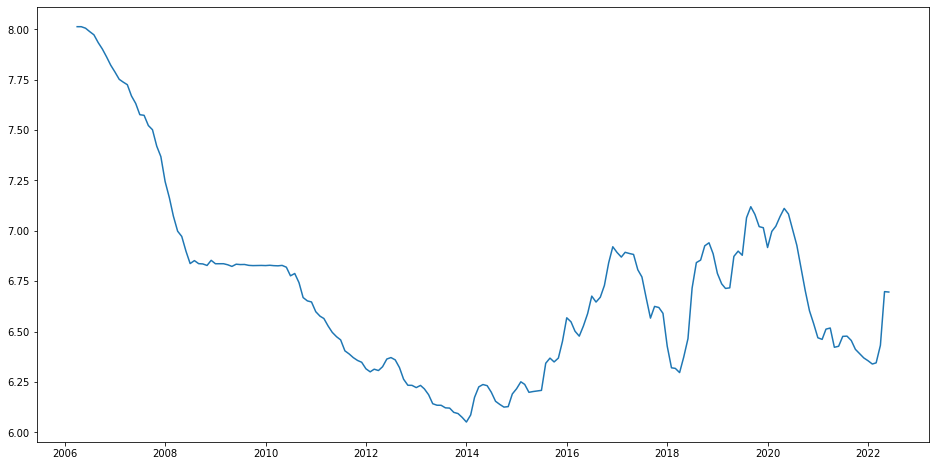

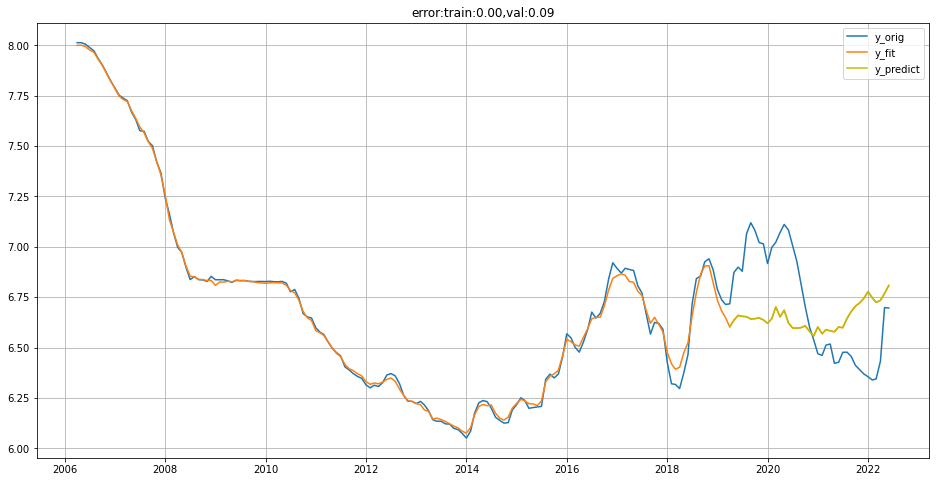

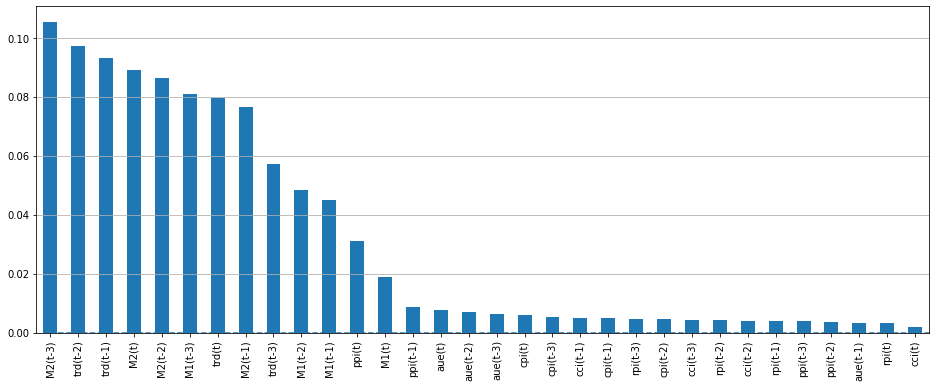

In [15]:
from sklearn.linear_model import  LassoCV, RidgeCV, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
# plot显示结果
def plot_result(y, y_fit, y_future):#y真实，y_fit拟合，y_future预测
    assert len(y) == len(y_fit)
    plt.figure(figsize=(16, 8))
    # plt.plot(y.index, y, "k.", label="y_orig")
    plt.plot(y.index, y, label="y_orig")
    plt.plot(y.index, y_fit, label="y_fit")
    plt.plot(y_future.index, y_future, "y", label="y_predict")
    error_val = mean_squared_error(y.iloc[-y_future.shape[0]:], y_future)
    error_train = mean_squared_error(y.iloc[:-y_future.shape[0]], y_fit[:-y_future.shape[0]])
    plt.title("error:train:{:0.2f},val:{:0.2f}".format(error_train,error_val))
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
   # predict

def predict_future(model, scaler, x_pred, y_pred, lag_start, lag_end):#model拟合的模型，scaler归一化，lag平移特征，x_pred/y_pred预测x和y
    
    y_pred[0:lag_start] = model.predict(scaler.transform(x_pred[0:lag_start]))  # 预测到lag_start上一行
    for i in range(lag_start, len(x_pred)):
        last_line = x_pred.iloc[i-1]  # 已经预测数据的最后一行,还没预测数据的上一行，即shift,上一行填充到斜角下一行
        index = x_pred.index[i]
        x_pred.at[index, "lag_{}".format(lag_start)] = y_pred[i-1]
        x_pred.at[index, "diff_lag_{}".format(lag_start)] = y_pred[i-1] -  x_pred.at[x_pred.index[i-1], "lag_{}".format(lag_start)]
        for j in range(lag_start + 1, lag_end):  # 根据平移变换shift，前一个lag_{}列的值，shift后为下一个列的值
            x_pred.at[index, "lag_{}".format(j)] = last_line["lag_{}".format(j-1)]
        # 已经预测的最后一个值，赋值给lag_start对应的"lag_{}.format(lag_start)列
        # x_pred.at[index, "lag_{}".format(lag_start)] = y_pred[i - 1]
        y_pred[i] = model.predict(scaler.transform([x_pred.iloc[i]]))[0]
    return y_pred


# coefs显示重要性
def plot_importance(model, x_train):
    if hasattr(model,'coef_'):
        coefs = pd.DataFrame(model.coef_, x_train.columns)
    else:
        coefs = pd.DataFrame(model.feature_importances_, x_train.columns)
    coefs.columns = ["coefs"]
    coefs["coefs_abs"] = coefs.coefs.apply(np.abs)
    coefs = coefs.sort_values(by="coefs_abs", ascending=False).drop(["coefs_abs"], axis=1)
    plt.figure(figsize=(16, 6))
    coefs.coefs.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed")
    plt.show()

# lag_start = 1#要根据数据周期，调试
# lag_end = 4#平移特征
# #随机森林
lr = RandomForestRegressor(n_estimators=200, max_depth=20) 
lr.fit(X_train_norm, Y_train)


y_future = lr.predict(X_val_norm)
y_future =pd.DataFrame(y_future)
y_future.index = Y_val.index

y_fit = lr.predict(np.concatenate((X_train_norm, X_val_norm)))

y = pd.concat([Y_train, Y_val])
# 显示结果
plt.figure(figsize=(16, 8))
plt.plot(data.index, data['usdcny(t)'])
plot_result(y, y_fit, y_future)

plot_importance(lr, X_train)





In [22]:
(max(M1.values)-min(M1.values))*0.09

array([56672.6229])